In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pca

In [17]:
from pca import pca
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
data_fname = '/content/drive/Shareddrives/martin_data/Chromatin Architecture Analyses Python/Mikroskop horní/zz_Original data files_results/results.xlsx'

df = pd.read_excel(data_fname)
df


# file_name example D:\kondenzace_jader\data\Chromatin Architecture Analyses Python\Mikroskop horní\zz_Original data files_results\Cell type 1 (FaDu) Irradiated - different times after irradiation\30min PI_IR 6Gy\rawdata\0001\01_cell_10_features.json
# crate new colum that will identify groups based on file_names - cell type number and iradiated vs non-irradianted

def extract_groups(path):
    pattern = re.compile(r'Cell type (\d+).*?(Irradiated|Non-irradiated)', re.IGNORECASE)
    match = pattern.search(path)
    if match:
        cell_type = f"Cell type {match.group(1)}"
        condition = match.group(2).capitalize()  # Irradiated / Non-irradiated
        return cell_type, condition
    return None, None

df[["cell_type", "condition"]] = df["file_name"].apply(
    lambda x: pd.Series(extract_groups(str(x)))
)

df["group"] = df["cell_type"] + " - " + df["condition"]


# show unique groups
df["group"].unique()


array(['Cell type 1 - Irradiated', 'Cell type 1 - Non-irradiated',
       'Cell type 2 - Irradiated', 'Cell type 2 - Non-irradiated',
       'Cell type 3 - Irradiated', 'Cell type 4 - Non-irradiated',
       'Cell type 4 - Irradiated', nan], dtype=object)

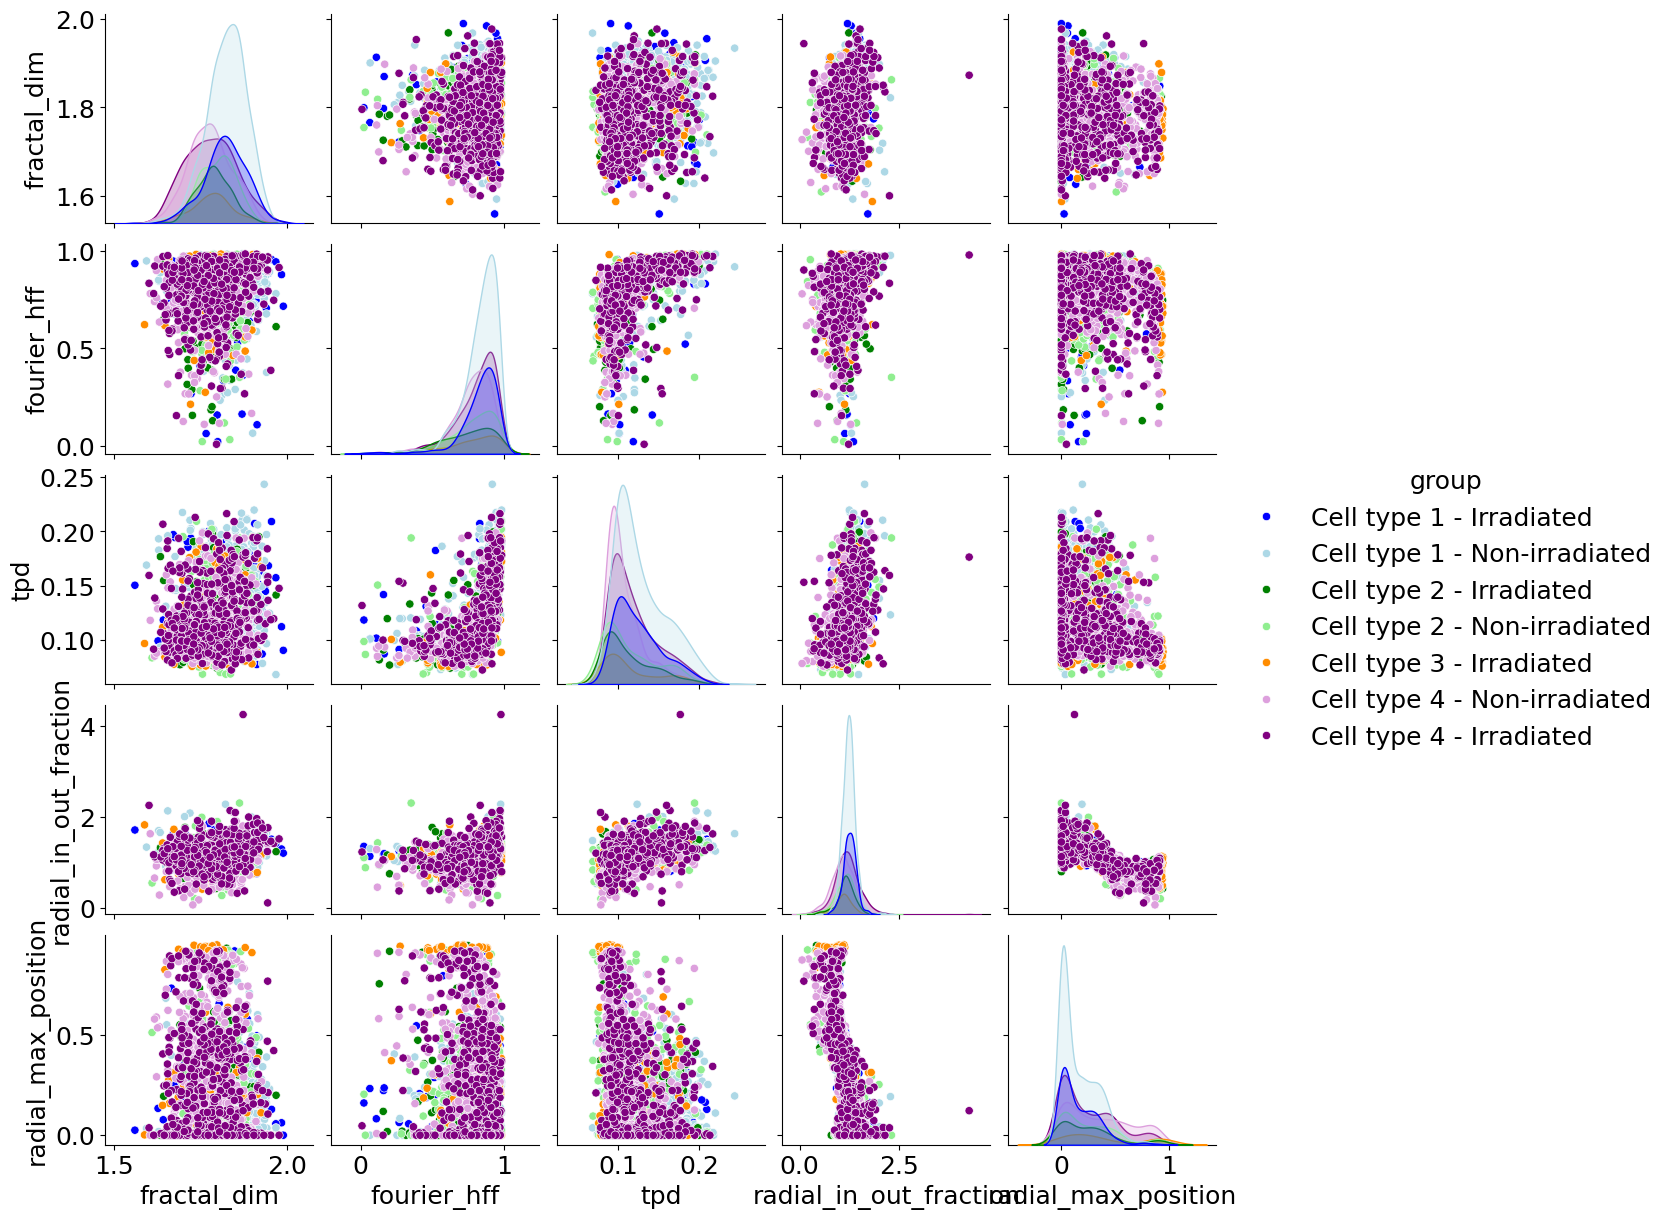

In [33]:
color_map = {
    "Cell type 1 - Non-irradiated": "lightblue",
    "Cell type 1 - Irradiated": "blue",

    "Cell type 2 - Non-irradiated": "lightgreen",
    "Cell type 2 - Irradiated": "green",

    "Cell type 3 - Non-irradiated": "navajowhite",   # light orange
    "Cell type 3 - Irradiated": "darkorange",

    "Cell type 4 - Non-irradiated": "plum",          # light purple
    "Cell type 4 - Irradiated": "purple"
}


sns.pairplot(df, hue="group", palette=color_map)
plt.show()
# sns.pairplot(df, hue="group", kind="kde", palette=color_map)
# plt.show()



[21-08-2025 10:44:12] [pca.pca] [INFO] Extracting column labels from dataframe.
[21-08-2025 10:44:12] [pca.pca] [INFO] Normalizing input data per feature (zero mean and unit variance)..
[21-08-2025 10:44:12] [pca.pca] [INFO] PCA reduction performed to capture 95.0% explained variance using 5 columns of the input data.
[21-08-2025 10:44:12] [pca.pca] [INFO] Fit using PCA.
[21-08-2025 10:44:12] [pca.pca] [INFO] Compute loadings and PCs.
[21-08-2025 10:44:12] [pca.pca] [INFO] Compute explained variance.
[21-08-2025 10:44:12] [pca.pca] [INFO] Number of components is 5 that covers 95.00% explained variance.
[21-08-2025 10:44:12] [pca.pca] [INFO] The PCA reduction is performed on the 5 columns of the input dataframe.
[21-08-2025 10:44:12] [pca.pca] [INFO] Fit using PCA.
[21-08-2025 10:44:12] [pca.pca] [INFO] Compute loadings and PCs.
[21-08-2025 10:44:12] [pca.pca] [INFO] Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[21-08-2025 10:44:13] [pca.pca] [INFO] M

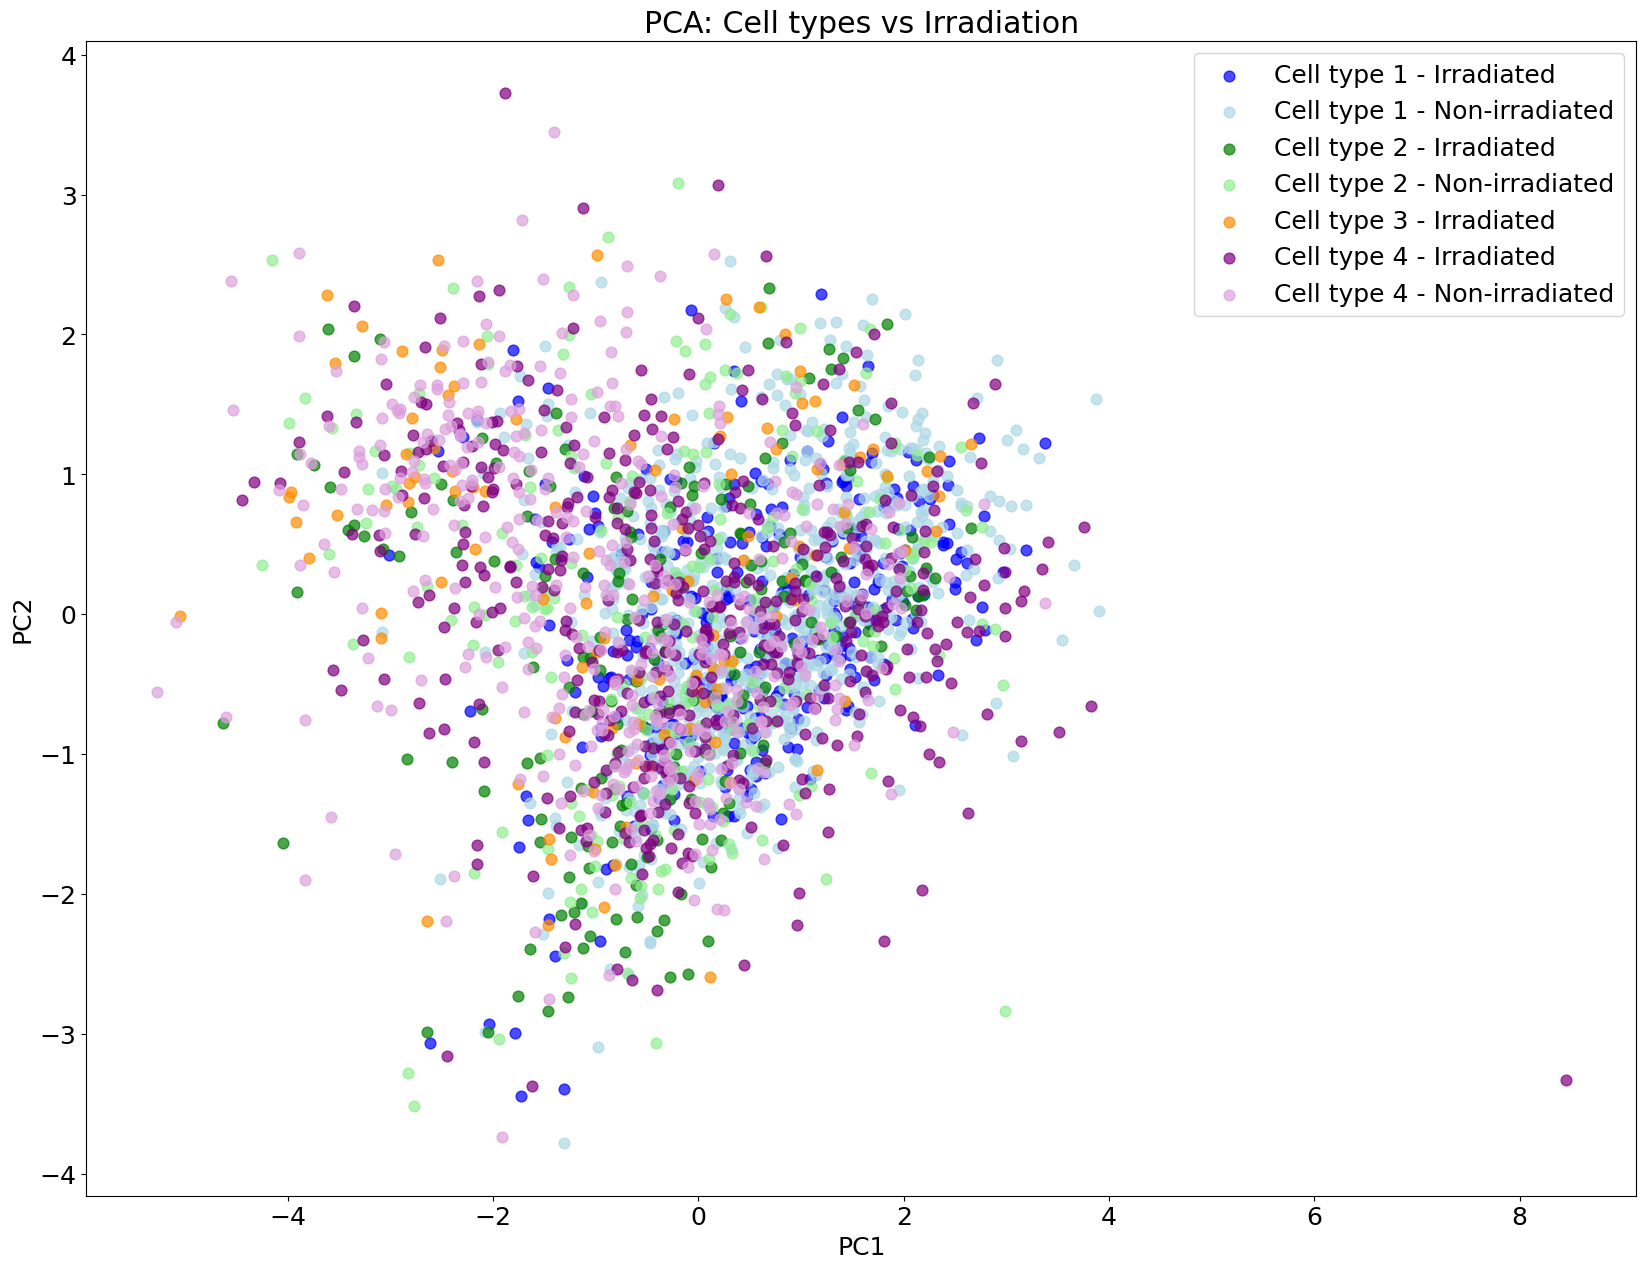

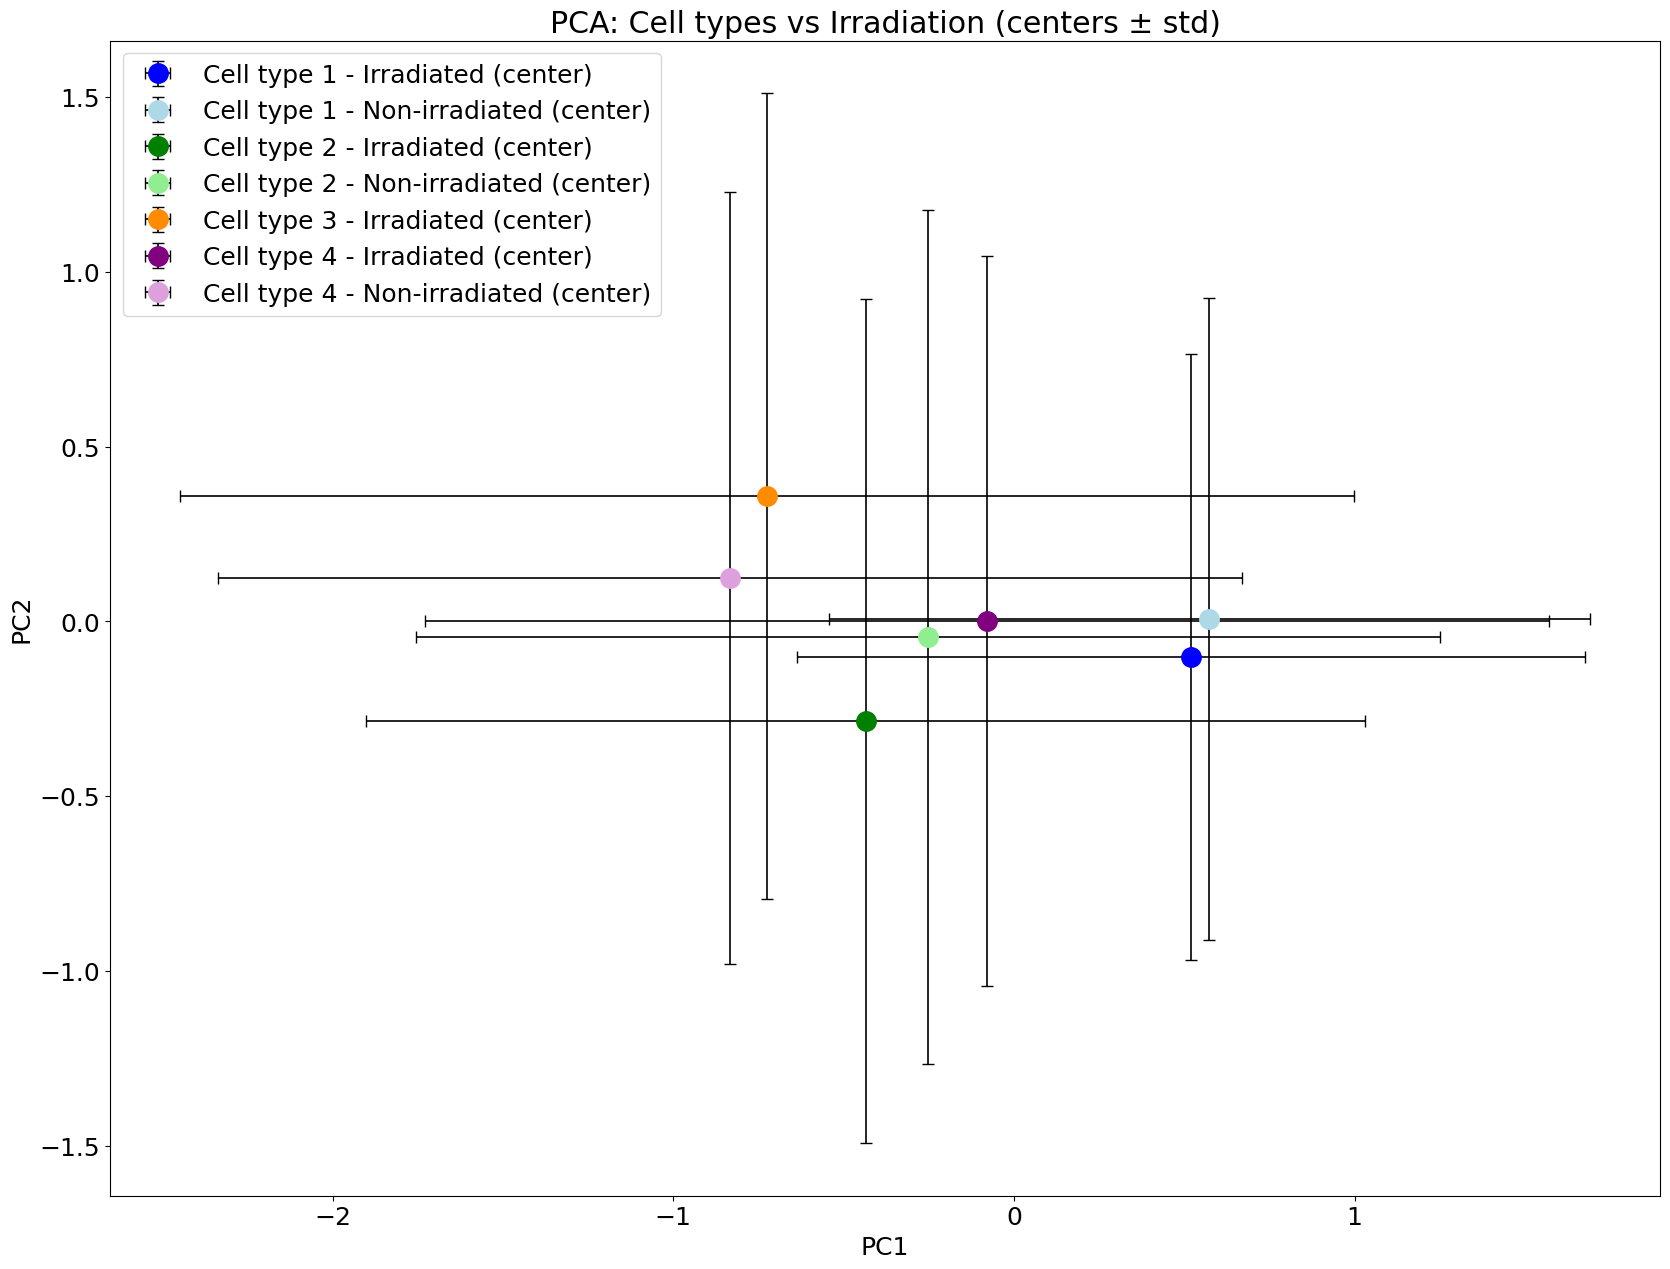

In [36]:
# pca
color_map = {
    "Cell type 1 - Non-irradiated": "lightblue",
    "Cell type 1 - Irradiated": "blue",

    "Cell type 2 - Non-irradiated": "lightgreen",
    "Cell type 2 - Irradiated": "green",

    "Cell type 3 - Non-irradiated": "navajowhite",   # light orange
    "Cell type 3 - Irradiated": "darkorange",

    "Cell type 4 - Non-irradiated": "plum",          # light purple
    "Cell type 4 - Irradiated": "purple"
}


# remove group nan
df = df.dropna(subset=["group"])

X = df.iloc[:, :-4]
y = df["group"]




# Fit PCA
model = pca(normalize=True)
results = model.fit_transform(X=X, row_labels=y)

# Extract scores
scores = results['PC']        # DataFrame with PC1, PC2, ...
scores['group'] = y.values
scores['cell_type'] = df['cell_type'].values
scores['condition'] = df['condition'].values

# Custom colors: 4 cell types × 2 conditions
color_map = {
    "Cell type 1 - Non-irradiated": "lightblue",
    "Cell type 1 - Irradiated": "blue",
    "Cell type 2 - Non-irradiated": "lightgreen",
    "Cell type 2 - Irradiated": "green",
    "Cell type 3 - Non-irradiated": "navajowhite",
    "Cell type 3 - Irradiated": "darkorange",
    "Cell type 4 - Non-irradiated": "plum",
    "Cell type 4 - Irradiated": "purple",
}

# Scatter plot manually
plt.figure(figsize=(20,15))
for g, sub in scores.groupby('group'):
    plt.scatter(sub["PC1"], sub["PC2"],
                label=g,
                color=color_map[g],
                alpha=0.7, s=60)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title("PCA: Cell types vs Irradiation")
plt.show()


# plot also just center with std plot




plt.figure(figsize=(20,15))

# # Scatter all points
# for g, sub in scores.groupby('group'):
#     plt.scatter(sub["PC1"], sub["PC2"],
#                 label=g,
#                 color=color_map[g],
#                 alpha=0.4, s=40)

# Overlay group centers with std error bars
for g, sub in scores.groupby('group'):
    mean_x = sub["PC1"].mean()
    mean_y = sub["PC2"].mean()
    std_x = sub["PC1"].std()
    std_y = sub["PC2"].std()

    plt.errorbar(mean_x, mean_y, xerr=std_x, yerr=std_y,
                 fmt='o', color=color_map[g], ecolor='black',
                 elinewidth=1.2, capsize=4, markersize=14,
                 label=f"{g} (center)")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.title("PCA: Cell types vs Irradiation (centers ± std)")
plt.show()



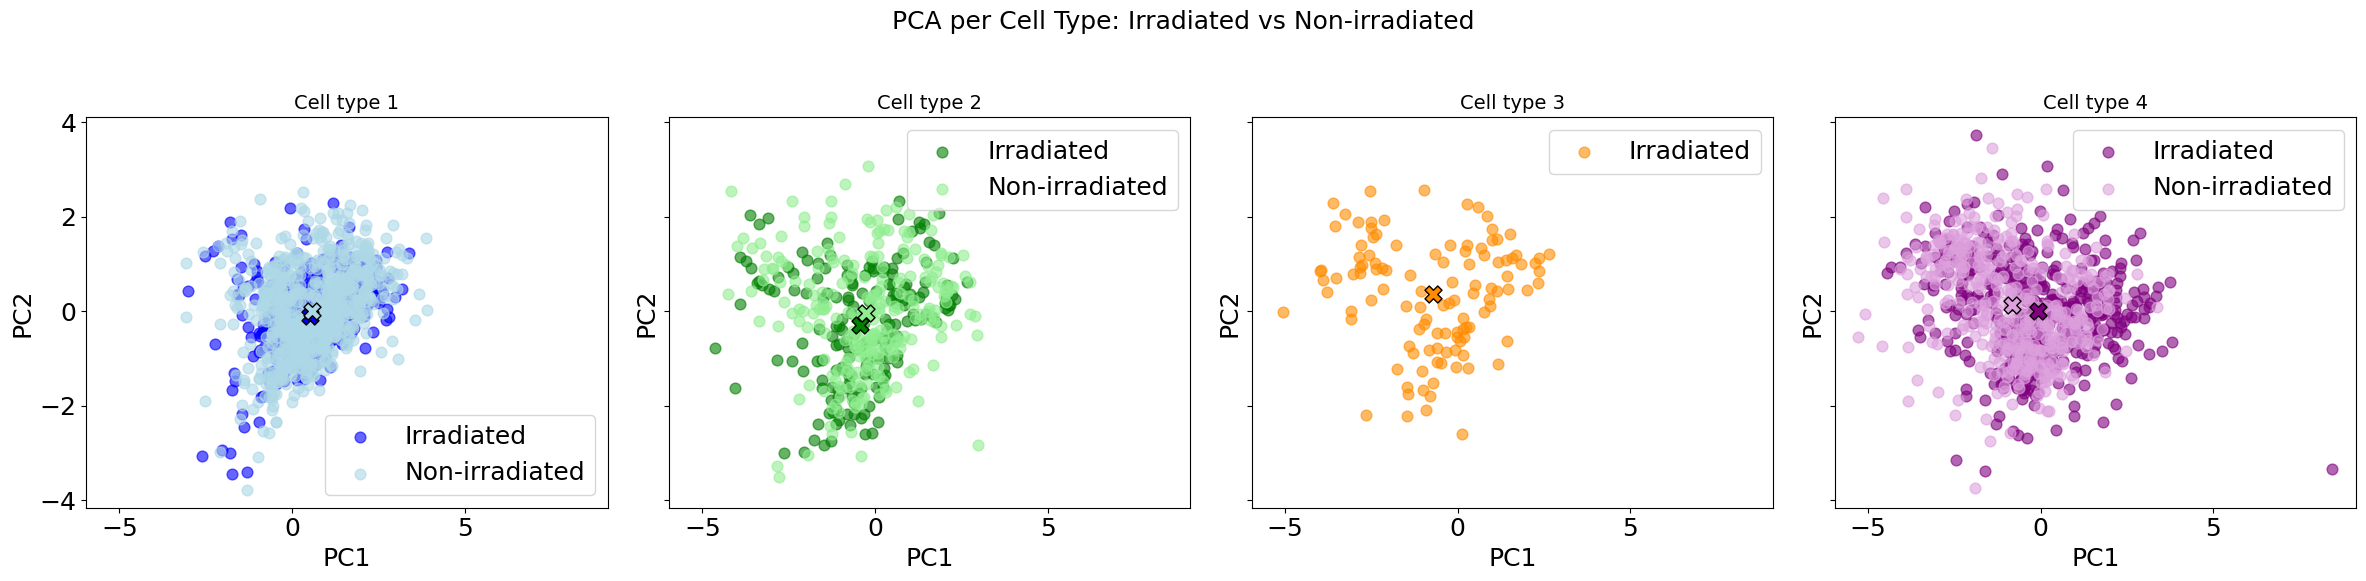

In [41]:
# now plot same pca for individual cell types - irradiated and noniradiated with diferent color

import matplotlib.pyplot as plt

cell_types = scores["cell_type"].unique()
n_types = len(cell_types)

fig, axes = plt.subplots(1, n_types, figsize=(6*n_types, 6), sharex=True, sharey=True)

if n_types == 1:
    axes = [axes]  # ensure iterable if only one cell type

for ax, ct in zip(axes, cell_types):
    sub = scores[scores["cell_type"] == ct]

    # plot irradiated vs non-irradiated separately
    for cond, subset in sub.groupby("condition"):
        ax.scatter(subset["PC1"], subset["PC2"],
                   label=cond,
                   color=color_map[f"{ct} - {cond}"],
                   alpha=0.6, s=60)

        # optional: add centroid
        mx, my = subset["PC1"].mean(), subset["PC2"].mean()
        ax.scatter(mx, my, marker="X", s=150,
                   color=color_map[f"{ct} - {cond}"], edgecolor="k", zorder=10)

    ax.set_title(f"{ct}", fontsize=14)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.legend()




plt.suptitle("PCA per Cell Type: Irradiated vs Non-irradiated", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.97])





